# Modeling for Snow Depth Prediction

This notebook is focused on preparing the data for modeling, addressing multicollinearity, and creating training, validation, and testing sets. We will proceed with the following steps:
- Loading the Processed Data
- Creating Lag Features and Derived Variables
- Handling Multicollinearity
- Splitting the Data into Training, Validation, and Testing Sets

### 1. Loading Libraries and Processed Data

# Modeling for Snow Depth Prediction

This notebook is focused on preparing the data for modeling, addressing multicollinearity, and creating training, validation, and testing sets. We will proceed with the following steps:
- Loading the Processed Data
- Creating Lag Features and Derived Variables
- Handling Multicollinearity
- Splitting the Data into Training, Validation, and Testing Sets
- Feature Selection Using Feature Importance
- Proceeding with Modeling
- Plotting Evaluation Metrics
- Saving the Model and Split Datasets

### 0. Adjust Python Path to Include 'src' Directory

In [1]:
import sys
import os
from pathlib import Path

# Determine the current directory of the notebook
current_dir = Path.cwd()

project_root = current_dir.parent

# Append the 'src' directory to the Python path if it's not already there
if str(project_root.resolve()) not in sys.path:
    sys.path.append(str(project_root.resolve()))
    print(f"Added '{project_root.resolve()}' to sys.path")
else:
    print(f"'{project_root.resolve()}' is already in sys.path")

Added '/workspace/SkiSnow' to sys.path


### 1. Loading Libraries and Processed Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

### 2. Load Processed Data

In [3]:
# Adjust the path based on your current working directory
data_path = os.path.join('..', 'data', 'processed', 'processed_data_for_modeling.csv')

# Load the combined processed data
model_data = pd.read_csv(data_path)

# Ensure 'date' column is in datetime format
model_data['date'] = pd.to_datetime(model_data['date'])

# Display the shape to confirm loading
print(f"Loaded combined data with shape {model_data.shape}")

Loaded combined data with shape (75592, 12)


### 3. Preparing Features and Target Variable

In [4]:
# Filter data for operating season
data_operating = model_data[model_data['is_operating_season'] == True].reset_index(drop=True)
print(f"Data shape after filtering for operating season: {data_operating.shape}")

# Define the target variable
y = data_operating['snow_depth']

# Exclude 'date' and 'snow_depth' from features
feature_columns = [col for col in data_operating.columns if col not in ['date', 'snow_depth']]

# Create the features DataFrame
X = data_operating[feature_columns].copy()

print("Excluded 'date' and 'snow_depth' from features.")
print(f"Final feature columns: {X.columns.tolist()}")
print(f"Initial shape of X: {X.shape}")
print(f"Initial shape of y: {y.shape}")

Data shape after filtering for operating season: (36461, 12)
Excluded 'date' and 'snow_depth' from features.
Final feature columns: ['temperature_min', 'temperature_max', 'precipitation_sum', 'season_id', 'is_operating_season', 'resort', 'snow_depth_lag1', 'snow_depth_lag7', 'temperature_avg', 'temperature_avg_squared']
Initial shape of X: (36461, 10)
Initial shape of y: (36461,)


#### 3.1. Plotting the Distribution of the Target Variable

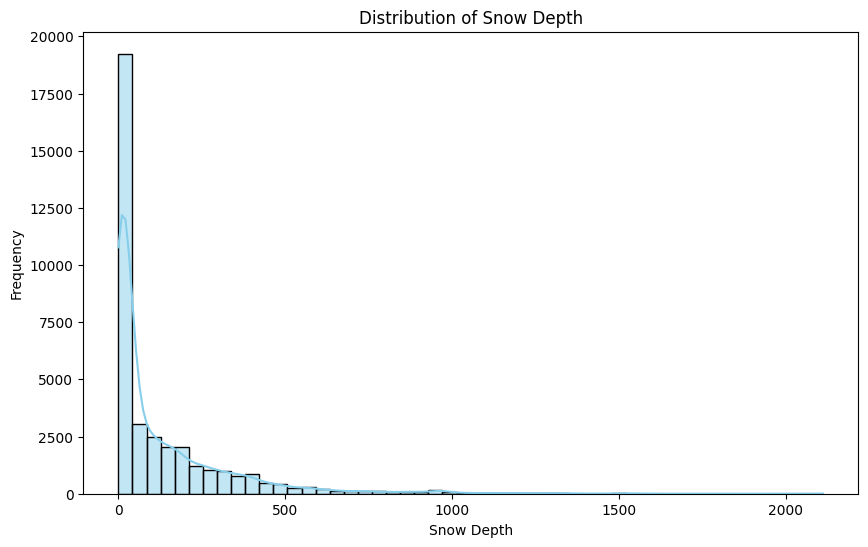

In [5]:
# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, bins=50, color='skyblue')
plt.title("Distribution of Snow Depth")
plt.xlabel("Snow Depth")
plt.ylabel("Frequency")
plt.show()

#### 3.2. Feature Engineering: Adding Polynomial Feature

In [6]:
# Create polynomial feature for 'temperature_avg'
X['temperature_avg_squared'] = X['temperature_avg'] ** 2
print("Added 'temperature_avg_squared' to features.")

Added 'temperature_avg_squared' to features.


#### 3.3. Creating Lagged Snow Depth Features

In [7]:
# Define lag periods
lags = [1, 7]  # Reverting to fewer lag features as per old code

# Features to create lag features for
lag_features = ['snow_depth']

for feature in lag_features:
    for lag in lags:
        lag_col = f"{feature}_lag{lag}"
        if feature in X.columns:
            X[lag_col] = X[feature].shift(lag)
            print(f"Created lag feature '{lag_col}'.")
        else:
            print(f"Feature '{feature}' not found in X. Skipping lag creation for this feature.")

# Drop rows with NaN values resulting from lagging
X = X.dropna().reset_index(drop=True)
y = y.iloc[X.index].reset_index(drop=True)

print(f"Shape of X after adding lag features: {X.shape}")
print(f"Shape of y after adding lag features: {y.shape}")

Feature 'snow_depth' not found in X. Skipping lag creation for this feature.
Feature 'snow_depth' not found in X. Skipping lag creation for this feature.
Shape of X after adding lag features: (36461, 10)
Shape of y after adding lag features: (36461,)


### 4. Handling Multicollinearity

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the DataFrame.

    Parameters:
    - X (pd.DataFrame): Feature matrix.

    Returns:
    - pd.DataFrame: DataFrame containing features and their VIF values.
    """
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# **Added code to handle non-numeric features**

# 1. Identify non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Non-numeric columns in X: {non_numeric_cols}")

# 2. One-Hot Encode non-numeric categorical columns
if non_numeric_cols:
    X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)
    print(f"Applied one-hot encoding to columns: {non_numeric_cols}")
else:
    print("No non-numeric categorical columns to encode.")

# 3. Identify and convert boolean columns to integers
bool_cols = X.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    X[bool_cols] = X[bool_cols].astype(int)
    print(f"Converted boolean columns to integers: {bool_cols}")
else:
    print("No boolean columns to convert.")

# 4. Verify all features are numeric
print("Data types of features in X after processing:")
print(X.dtypes)

# Ensure there are no non-numeric columns left
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if non_numeric_cols:
    print(f"Warning: There are still non-numeric columns: {non_numeric_cols}")
    # Decide how to handle them (drop or encode)
    # For this example, we'll drop them
    X = X.drop(columns=non_numeric_cols)
    print(f"Dropped remaining non-numeric columns: {non_numeric_cols}")
else:
    print("All features are now numeric.")

# 5. Handle missing or infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
if X.isnull().sum().sum() > 0:
    X.fillna(X.mean(), inplace=True)
    print("Handled missing and infinite values in X.")
else:
    print("No missing or infinite values in X.")

# **Proceed with VIF calculation**

# Initial VIF Calculation
print("Calculating initial VIF for all features.")
vif_data = calculate_vif(X)
print(vif_data.sort_values('VIF', ascending=False))

# Function to iteratively remove features with high VIF
def remove_high_vif_features(X, vif_threshold=10):
    """
    Iteratively remove features with VIF greater than the threshold.

    Parameters:
    - X (pd.DataFrame): Feature matrix.
    - vif_threshold (float): Threshold for VIF to determine feature removal.

    Returns:
    - pd.DataFrame: Cleaned feature matrix with VIF below the threshold.
    - pd.DataFrame: DataFrame containing final VIF values.
    """
    while True:
        vif_data = calculate_vif(X)
        # Identify features with VIF > threshold
        high_vif = vif_data[vif_data['VIF'] > vif_threshold]
        if high_vif.empty:
            break
        # Remove the feature with the highest VIF
        feature_to_remove = high_vif.sort_values('VIF', ascending=False)['Feature'].iloc[0]
        print(f"Removing feature '{feature_to_remove}' with VIF={high_vif['VIF'].max():.2f} > {vif_threshold}")
        X = X.drop(columns=[feature_to_remove])
    
    # Final VIF calculation
    final_vif = calculate_vif(X)
    return X, final_vif

# Set VIF threshold
vif_threshold = 10

# Remove high VIF features
X_cleaned, final_vif = remove_high_vif_features(X, vif_threshold=vif_threshold)

print("Final VIF after removing multicollinear features:")
print(final_vif.sort_values('VIF', ascending=False))

Non-numeric columns in X: ['season_id', 'resort']
Applied one-hot encoding to columns: ['season_id', 'resort']
Converted boolean columns to integers: ['is_operating_season', 'season_id_1991-1992', 'season_id_1992-1993', 'season_id_1993-1994', 'season_id_1994-1995', 'season_id_1995-1996', 'season_id_1996-1997', 'season_id_1997-1998', 'season_id_1998-1999', 'season_id_1999-2000', 'season_id_2000-2001', 'season_id_2001-2002', 'season_id_2002-2003', 'season_id_2003-2004', 'season_id_2004-2005', 'season_id_2005-2006', 'season_id_2006-2007', 'season_id_2007-2008', 'season_id_2008-2009', 'season_id_2009-2010', 'season_id_2010-2011', 'season_id_2011-2012', 'season_id_2012-2013', 'season_id_2013-2014', 'season_id_2014-2015', 'season_id_2015-2016', 'season_id_2016-2017', 'season_id_2017-2018', 'season_id_2018-2019', 'season_id_2019-2020', 'season_id_2020-2021', 'season_id_2021-2022', 'season_id_2022-2023', 'season_id_2023-2024', 'resort_kitzbuhel', 'resort_kranjska_gora', 'resort_krvavec', 'reso

/workspace/SkiSnow/venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                      Feature        VIF
0             temperature_min        inf
1             temperature_max        inf
6             temperature_avg        inf
3         is_operating_season  87.379796
46              resort_solden   5.947099
41           resort_kitzbuhel   5.659454
47            resort_st_anton   5.043619
43             resort_krvavec   4.700013
44  resort_mariborsko_pohorje   4.613103
42       resort_kranjska_gora   4.524430
4             snow_depth_lag1   3.811736
45           resort_sestriere   3.759167
5             snow_depth_lag7   3.657815
48           resort_st_moritz   3.233748
39        season_id_2022-2023   2.702058
26        season_id_2009-2010   2.650910
28        season_id_2011-2012   2.612820
27        season_id_2010-2011   2.608771
30        season_id_2013-2014   2.586020
31        season_id_2014-2015   2.567676
29        season_id_2012-2013   2.551738
24        season_id_2007-2008   2.533310
25        season_id_2008-2009   2.503010
36        season

/workspace/SkiSnow/venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature 'temperature_min' with VIF=inf > 10
Removing feature 'is_operating_season' with VIF=87.38 > 10
Removing feature 'temperature_max' with VIF=23.19 > 10
Final VIF after removing multicollinear features:
                      Feature       VIF
1             snow_depth_lag1  5.416664
2             snow_depth_lag7  5.178911
43              resort_solden  4.280861
38           resort_kitzbuhel  4.133500
44            resort_st_anton  3.599503
40             resort_krvavec  3.461748
39       resort_kranjska_gora  3.363387
41  resort_mariborsko_pohorje  3.215551
42           resort_sestriere  2.683752
45           resort_st_moritz  2.380843
3             temperature_avg  1.980635
4     temperature_avg_squared  1.855951
22        season_id_2008-2009  1.740880
27        season_id_2013-2014  1.722758
23        season_id_2009-2010  1.715234
25        season_id_2011-2012  1.709603
31        season_id_2017-2018  1.694011
36        season_id_2022-2023  1.691447
26        season_id_201

### 5. Splitting the Data into Training, Validation, and Testing Sets

In [9]:
# Define the sizes for training, validation, and testing sets
total_length = len(X_cleaned)
train_size = int(0.7 * total_length)
val_size = int(0.15 * total_length)
test_size = total_length - train_size - val_size

print(f"Total samples: {total_length}")
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

# Split the data based on indices to maintain temporal order
X_train = X_cleaned.iloc[:train_size].reset_index(drop=True)
y_train = y.iloc[:train_size].reset_index(drop=True)

X_val = X_cleaned.iloc[train_size:train_size + val_size].reset_index(drop=True)
y_val = y.iloc[train_size:train_size + val_size].reset_index(drop=True)

X_test = X_cleaned.iloc[train_size + val_size:].reset_index(drop=True)
y_test = y.iloc[train_size + val_size:].reset_index(drop=True)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation set shape: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

# Verify alignment
assert X_train.shape[0] == y_train.shape[0], "Mismatch in training set."
assert X_val.shape[0] == y_val.shape[0], "Mismatch in validation set."
assert X_test.shape[0] == y_test.shape[0], "Mismatch in test set."

print("All splits are aligned correctly.")

Total samples: 36461
Training set size: 25522
Validation set size: 5469
Test set size: 5470
Training set shape: X_train=(25522, 47), y_train=(25522,)
Validation set shape: X_val=(5469, 47), y_val=(5469,)
Test set shape: X_test=(5470, 47), y_test=(5470,)
All splits are aligned correctly.


### 6. Feature Selection Using Feature Importance

In [10]:
# Fit a temporary Random Forest model to get feature importances
rf_temp = RandomForestRegressor(random_state=42)
rf_temp.fit(X_cleaned, y)

# Retrieve feature importances
importances = rf_temp.feature_importances_
feature_names = X_cleaned.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance and select the top N features
N = 20
top_features = importance_df.sort_values(by='Importance', ascending=False).head(N)['Feature'].tolist()

# Filter X_train, X_val, X_test to include only the top features
X_train = X_train[top_features]
X_val = X_val[top_features] 
X_test = X_test[top_features]

print(f"Top {N} features selected based on feature importance:")
print(top_features)

Top 20 features selected based on feature importance:
['snow_depth_lag1', 'temperature_avg', 'temperature_avg_squared', 'precipitation_sum', 'snow_depth_lag7', 'season_id_2010-2011', 'season_id_1995-1996', 'season_id_2001-2002', 'resort_solden', 'resort_sestriere', 'resort_st_moritz', 'resort_st_anton', 'season_id_1998-1999', 'resort_kitzbuhel', 'resort_mariborsko_pohorje', 'season_id_2014-2015', 'season_id_2011-2012', 'season_id_2008-2009', 'resort_krvavec', 'season_id_1994-1995']


### 6. Proceeding with Modeling

In [11]:
# Initialize and train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on validation and test sets
y_val_pred_lr = lr.predict(X_val)
y_test_pred_lr = lr.predict(X_test)

# Calculate metrics
mse_val_lr = mean_squared_error(y_val, y_val_pred_lr)
r2_val_lr = r2_score(y_val, y_val_pred_lr)

mse_test_lr = mean_squared_error(y_test, y_test_pred_lr)
r2_test_lr = r2_score(y_test, y_test_pred_lr)

print("Linear Regression Evaluation on Validation Set:")
print(f"Mean Squared Error: {mse_val_lr:.2f}")
print(f"R-squared: {r2_val_lr:.2f}")

print("\nLinear Regression Evaluation on Test Set:")
print(f"Mean Squared Error: {mse_test_lr:.2f}")
print(f"R-squared: {r2_test_lr:.2f}")

Linear Regression Evaluation on Validation Set:
Mean Squared Error: 1236.45
R-squared: 0.86

Linear Regression Evaluation on Test Set:
Mean Squared Error: 2146.81
R-squared: 0.95


### 8. Saving the Model and splitting databases

In [12]:
# **Import Utility Functions**
from src.models.utils import save_model, save_split_datasets

# Define paths using the current working directory
model_save_dir = os.path.join(current_dir, 'src', 'models')
model_save_path_lr = os.path.join(model_save_dir, 'linear_regression_model.pkl')

modeling_data_dir = os.path.join(current_dir, 'data', 'processed', 'modeling_data')

# Save the trained Linear Regression model
save_model(lr, model_save_path_lr)

# Save the split datasets
save_split_datasets(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    modeling_data_dir
)

2024-11-04 13:52:22,683 - INFO - Model successfully saved to /workspace/SkiSnow/notebooks/src/models/linear_regression_model.pkl
2024-11-04 13:52:23,048 - INFO - Split datasets successfully saved to /workspace/SkiSnow/notebooks/data/processed/modeling_data


### 9. Loading and Testing the Saved Model

In [13]:
from src.models.utils import load_model, evaluate_model
import pandas as pd
import os
from pathlib import Path

# Define paths
# Note: project_root is already defined in the initial path adjustment cell
model_path = os.path.join(project_root, 'src', 'models', 'linear_regression_model.pkl')
modeling_data_dir = os.path.join(project_root, 'data', 'processed', 'modeling_data')

# Load the model
lr_model = load_model(model_path)

# Load validation data
X_val = pd.read_csv(os.path.join(modeling_data_dir, 'X_val.csv'))
y_val = pd.read_csv(os.path.join(modeling_data_dir, 'y_val.csv')).squeeze()

# Predict and evaluate
mse_val, r2_val, y_val_pred = evaluate_model(lr_model, X_val, y_val)
print(f"Validation MSE: {mse_val:.2f}")
print(f"Validation R²: {r2_val:.2f}")

2024-11-04 13:52:23,061 - INFO - Model successfully loaded from /workspace/SkiSnow/src/models/linear_regression_model.pkl
2024-11-04 13:52:23,071 - INFO - Model evaluation completed: MSE=1236.45, R2=0.86
Validation MSE: 1236.45
Validation R²: 0.86


In [14]:
print(type(lr_model))


<class 'sklearn.linear_model._base.LinearRegression'>
